In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import gym
import numpy as np
import nengo
import scipy.special

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

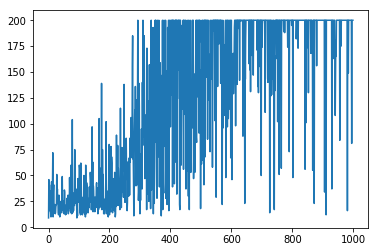

In [117]:
seed = 544

env = gym.make('CartPole-v0')
env.seed(seed)

rng = np.random.RandomState(seed=seed)

class Policy(object):
    def __init__(self, n_neurons=128, dimensions=4, seed=seed):
        self.model = nengo.Network(seed=seed)
        with self.model:
            self.ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                                      radius=2,
                                      #neuron_type=nengo.Sigmoid(),
                                      neuron_type=nengo.RectifiedLinear(),
                                     )
        self.sim = nengo.Simulator(self.model)
        
        self.w = np.zeros((3, n_neurons))
        
    def forward(self, x):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        y = self.w.dot(act)
        return y
    
    def train(self, x, error, learning_rate=1e-4):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        
        delta = error.T.dot(act)
        self.w += -learning_rate*delta
        
        
def log_prob(probs):
    #eps = 1e-6
    #p = np.clip(probs, eps, 1-eps)
    p = probs
    return np.log(p)
    
def select_action(state):
    y = p.forward(state)
    probs = y[:-1]
    probs = scipy.special.softmax(probs)
    action = rng.choice(np.arange(2), p=probs)
    log_probs = log_prob(probs)
    value = y[-1]
    return action, log_probs, value

def do_episode():
    history = []
    state = env.reset()
    state[2]*=5
    ep_reward = 0
    for i in range(10000):
        action, log_prob, value = select_action(state)
        state2, reward, done, _ = env.step(action)        
        state2[2]*=5
        history.append((state, action, state2, reward, log_prob, value))
        state = state2
        if done:
            break
    return history

def do_training(history, gamma=0.99, learning_rate=1e-4):
    returns = []
    R = 0
    for h in history[::-1]:
        r = h[3]
        R = r + gamma * R
        returns.insert(0, R)
    returns = np.array(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-6)
    
    #if len(history) == 200:
    #    returns[:] = 1
    
    train_state = []
    train_error = []
    for i, h in enumerate(history):
        R = returns[i]
        value = h[5]
        advantage = R - value
        action = h[1]
        state = h[0]
        log_probs = h[4]        
        error_action = np.zeros(2)
        if action == 0:
            error_action[0] = advantage*(1-np.exp(log_probs[0]))
            error_action[1] = -advantage*np.exp(log_probs[1])
        elif action == 1:
            error_action[0] = -advantage*np.exp(log_probs[0])
            error_action[1] = advantage*(1-np.exp(log_probs[1]))
        
        error_value = value - R
        error = np.hstack([-error_action, error_value])
        train_state.append(state)
        train_error.append(error)
    
    p.train(np.array(train_state), np.array(train_error), learning_rate=learning_rate)
        

p = Policy()

rs = []
hs = []
for i in range(1000):
    h = do_episode()
    hs.append(h)
    rs.append(len(h))
    #if len(h) < 200:
    do_training(h, gamma=0.99, learning_rate=1e-8)#*(400-i)/400)
    
plt.plot(rs)

In [104]:
print(np.where(np.array([len(hh) for hh in hs])==200))

h = hs[999]

(array([293, 310, 337, 350, 352, 357, 362, 374, 379, 384, 394, 398, 399,
       404, 406, 408, 410, 415, 416, 418, 419, 420, 422, 426, 428, 429,
       432, 433, 442, 444, 448, 449, 455, 460, 465, 472, 475, 484, 487,
       488, 492, 495, 497, 504, 507, 511, 513, 515, 518, 521, 524, 531,
       536, 540, 542, 543, 544, 545, 547, 549, 551, 552, 553, 554, 556,
       557, 558, 561, 562, 563, 564, 566, 567, 572, 581, 585, 586, 589,
       593, 597, 600, 611, 612, 615, 616, 617, 618, 620, 621, 623, 624,
       625, 626, 628, 629, 630, 632, 633, 634, 635, 636, 637, 640, 642,
       643, 645, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 659,
       660, 662, 664, 666, 668, 669, 670, 671, 673, 674, 675, 676, 677,
       678, 679, 680, 681, 682, 683, 684, 686, 688, 690, 691, 692, 693,
       694, 696, 697, 699, 700, 703, 704, 705, 706, 707, 708, 709, 710,
       712, 713, 714, 715, 716, 717, 718, 721, 722, 723, 724, 727, 728,
       729, 731, 736, 739, 744, 745, 746, 748, 750, 751, 753, 7

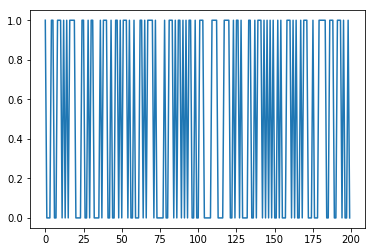

In [105]:
plt.plot([hh[1] for hh in h])

In [106]:
for (state, action, state2, reward, log_prob, value) in h:
    print(state)

[-0.03324212  0.02822643  0.02428813  0.00085206]
[-0.03267759  0.22327838  0.02437334 -0.29029427]
[-0.02821203  0.02808726 -0.00465609  0.00392208]
[-0.02765028 -0.16702133 -0.00426388  0.29631105]
[-0.03099071 -0.36213111  0.02536722  0.5887249 ]
[-0.03823333 -0.16708057  0.08423971  0.29764444]
[-0.04157494  0.02779721  0.11400416  0.01032232]
[-0.041019   -0.16764419  0.11503639  0.31011108]
[-0.04437188 -0.36308626  0.1460475   0.60996013]
[-0.05163361 -0.16838452  0.20704351  0.32661849]
[-0.0550013   0.02612416  0.23970536  0.04727624]
[-0.05447881  0.22052706  0.24443298 -0.22990379]
[-0.05006827  0.02474185  0.2214426   0.0777901 ]
[-0.04957343  0.21920184  0.22922161 -0.20059729]
[-0.0451894   0.02345521  0.20916188  0.10618766]
[-0.04472029  0.2179535   0.21978065 -0.1730094 ]
[-0.04036122  0.0222309   0.20247971  0.13320986]
[-0.03991661  0.21675009  0.2158007  -0.14642715]
[-0.0355816   0.41122824  0.20115798 -0.42518757]
[-0.02735704  0.6057579   0.15863923 -0.70492105]


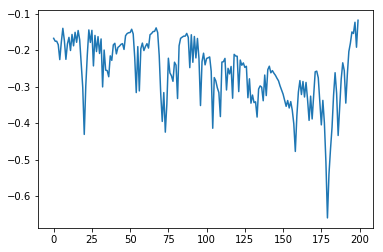

In [107]:
plt.plot([hh[5] for hh in h])

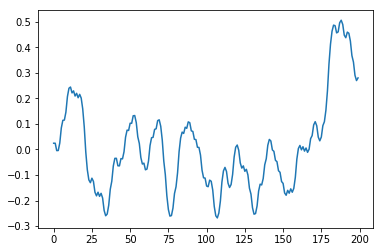

In [108]:
plt.plot([hh[0][2] for hh in h])

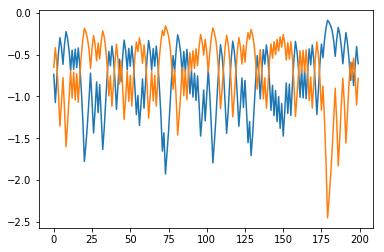

In [109]:
plt.plot([hh[4][1] for hh in h])
plt.plot([hh[4][0] for hh in h])

